# ts_q1

Text Input:
```
2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos
 
2000 01 01 01    -6   -78 10206   230    26     2     0 -9999 bos
 
2000 01 01 02   -17   -78 10211   230    36     0     0 -9999 bos
 
2000 01 01 03   -17   -78 10214   230    36     0     0 -9999 bos
 
2000 01 01 04   -17   -78 10216   230    36     0     0 -9999 bos
```

Predict the __current__ temp based on timestamp and city.

In [16]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.externals import joblib

%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

import scipy as sp
import matplotlib.pyplot as plt
import pylab as pylab
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
import statsmodels.api as sm

In [176]:
## CONSTANTS ###
# PATH_DATA = '/home/vagrant/miniprojects/questions/3_week/ts/data/'
# PATH_PKL = '/home/vagrant/miniprojects/questions/3_week/ts/pickles/'

PATH_DATA = '~/Dev/Data_Incubator/miniprojects/questions/3_week/ts/data/'


In [463]:
## Load Data ###
file = PATH_DATA +'tiny_train2.txt'
features = ['year', 'month', 'day', 'hour', 'temp', 'dew_temp', 'pressure', 'wind_angle', 'wind_speed', 'sky_code', 'rain_hour', 'rain_6hour', 'city',]
data = pd.read_table(file, sep=r"\s*", names=features, header=None, encoding='latin-1', engine='python')

data = data.iloc[:, [0,1,2,3,4,12]]


In [464]:
data.shape

(2000, 6)

In [465]:
print data.head()
print data.tail()

   year  month  day  hour  temp city
0  2011     11   22    16    67  bos
1  2011     11   22    17    72  bos
2  2011     11   22    18    72  bos
3  2011     11   22    19    67  bos
4  2011     11   22    20    67  bos
      year  month  day  hour  temp city
1995  2000      2   13    21     0  bal
1996  2000      2   13    22     0  bal
1997  2000      2   13    23     0  bal
1998  2000      2   14     0     0  bal
1999  2000      2   14     1     6  bal


In [466]:
## Convert date nums to strings ###
data['year'] = data['year'].astype(str)
data['month'] = data['month'].astype(str)
data['day'] = data['day'].astype(str)
data['hour'] = data['hour'].astype(str)

In [467]:
# replace leading zeroes
for row in range(0, len(data)):
    for col in range(1,4):
        if len(data.iloc[row,col]) < 2: 
                data.iloc[row,col] = ('0' + data.iloc[row,col])


In [468]:

print data.head()
print data.tail()

   year month day hour  temp city
0  2011    11  22   16    67  bos
1  2011    11  22   17    72  bos
2  2011    11  22   18    72  bos
3  2011    11  22   19    67  bos
4  2011    11  22   20    67  bos
      year month day hour  temp city
1995  2000    02  13   21     0  bal
1996  2000    02  13   22     0  bal
1997  2000    02  13   23     0  bal
1998  2000    02  14   00     0  bal
1999  2000    02  14   01     6  bal


In [469]:
## Join Date Strings
d = data

# join date strings for later timestamp conversion
d['timestamp'] = d['year'].astype(str) + ',' + d['month'].astype(str) + ',' + d['day'].astype(str)+ ',' + d['hour'].astype(str)   

# join dates without years for later sorting
d['mdh'] = d['month'].astype(str) + d['day'].astype(str) + d['hour'].astype(str)

print type(d.timestamp[0]), d.timestamp[0]

<type 'str'> 2011,11,22,16


In [470]:
## Cast to timestamp ###
d.timestamp = pd.to_datetime(d.timestamp)

# print type(d.timestamp[0]), d.timestamp[0]
print data.head()
print data.tail()

   year month day hour  temp city           timestamp     mdh
0  2011    11  22   16    67  bos 2011-11-22 16:00:00  112216
1  2011    11  22   17    72  bos 2011-11-22 17:00:00  112217
2  2011    11  22   18    72  bos 2011-11-22 18:00:00  112218
3  2011    11  22   19    67  bos 2011-11-22 19:00:00  112219
4  2011    11  22   20    67  bos 2011-11-22 20:00:00  112220
      year month day hour  temp city           timestamp     mdh
1995  2000    02  13   21     0  bal 2000-02-13 21:00:00  021321
1996  2000    02  13   22     0  bal 2000-02-13 22:00:00  021322
1997  2000    02  13   23     0  bal 2000-02-13 23:00:00  021323
1998  2000    02  14   00     0  bal 2000-02-14 00:00:00  021400
1999  2000    02  14   01     6  bal 2000-02-14 01:00:00  021401


In [471]:
## Restore df

df_data = d.loc[:,['timestamp','temp', 'city', 'mdh']]

print df_data.shape
df_data.head()

(2000, 4)


,timestamp,temp,city,mdh
0,2011-11-22 16:00:00,67,bos,112216
1,2011-11-22 17:00:00,72,bos,112217
2,2011-11-22 18:00:00,72,bos,112218
3,2011-11-22 19:00:00,67,bos,112219
4,2011-11-22 20:00:00,67,bos,112220


Axes(0.125,0.125;0.775x0.775)


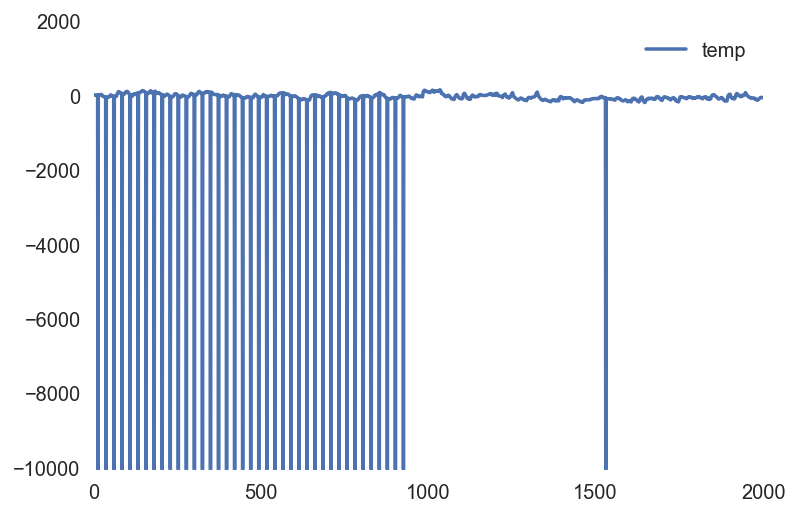

In [472]:
p = data.plot()
p.xaxis.axis_name = "Hours"
p.yaxis.axis_name = "Temp"
print p

In [473]:
## Clean NaNs ###
# An Exploratory Print shows some temp = -9999, equivalent to NaN
# Replace with an average interpolation

# Identify indices of temperature NaNs
ix_nan = df_data[df_data.temp == -9999].index.tolist()

# for each ~NaN, avg adjacent temps
for ix_row in ix_nan:
    flt_avg_tmp = 0.5*(df_data.ix[ix_row - 1,'temp'] + df_data.ix[ix_row + 1,'temp'])
    df_data.ix[ix_row,'temp'] = flt_avg_tmp


df_data.head()

,timestamp,temp,city,mdh
0,2011-11-22 16:00:00,67,bos,112216
1,2011-11-22 17:00:00,72,bos,112217
2,2011-11-22 18:00:00,72,bos,112218
3,2011-11-22 19:00:00,67,bos,112219
4,2011-11-22 20:00:00,67,bos,112220


Axes(0.125,0.125;0.775x0.775)


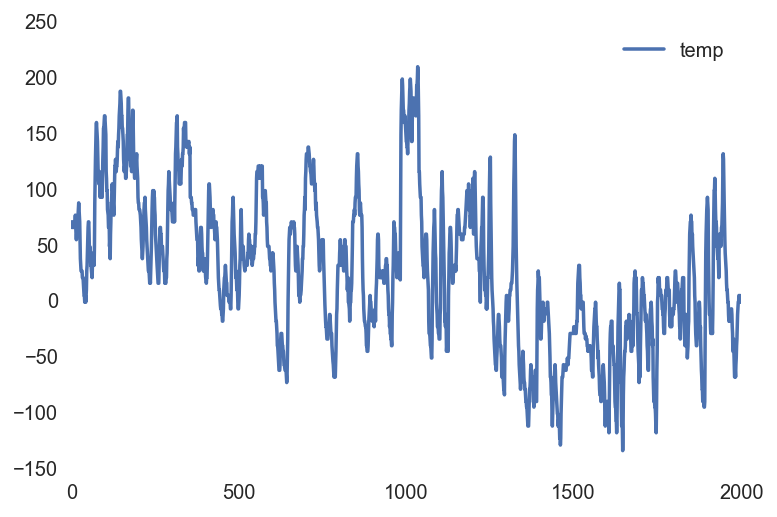

In [474]:
p = df_data.plot()
p.xaxis.axis_name = "Hours"
p.yaxis.axis_name = "Temp"
print p

In [475]:
## Set MultiIndex ###
ix = pd.MultiIndex.from_arrays([df_data['city'], df_data['mdh']], names=['city','mdh'])
df_data = df_data.set_index(ix)
del(ix)

In [476]:
## Define Training Sets ###
# at this point, data is clean; split X and y

lst_tpl_X = list(df_data.loc[:,['timestamp','city']].itertuples())
lst_y = df_data.temp.tolist()

y = lst_y  # temperature
X = lst_tpl_X  # (index, timestamp, city)

In [477]:
## Aggregate by City ###
gb_temps_by_city = df_data.groupby(by=['city'])  # separate records by city
gb = gb_temps_by_city

print gb.get_group('bos').head(1)
list(gb.groups.iterkeys())

                      timestamp  temp city     mdh
city mdh                                          
bos  112216 2011-11-22 16:00:00    67  bos  112216


['bal', 'bos']

In [481]:
# Aggregate & train
lst_city = []
lst_mdh = []
lst_avg_temp = []

for k_city, df_years in gb_temps_by_city:
    gb_mdh = df_years.groupby('mdh') # aggregate annual measurements for each day+hour
    #print k_city, list(gb_hours.groups.iterkeys())

    i = 0 # meSUREMENT COUNTER
    for k_mdh, df_annual_temps in gb_mdh:  # for each set of annual measurements
        avg_hourly_temp = df_annual_temps.temp.mean()
        lst_avg_temp.append(avg_hourly_temp) # avg hourly temp over years
        lst_city.append(k_city)
        lst_mdh.append(k_mdh)
        i += 1
        
#         if k_city == 'bos' and len(df_annual_temps)>1:
#             print k_city, k_mdh, df_annual_temps.shape, ' | '#, df_annual_temps.temp#
# #           print k_mdh, ' | ', avg_hourly_temp, ' | ', df_annual_temps.temp.item()#
#             pass
    print '----------------------------------------------------'
    print 'Number of hourly averages in', k_city, ':', i
    print 'Number of temp measurements in', k_city, ':', len(df_years)
    print '----------------------------------------------------'
df_avg_temps = pd.DataFrame()
df_avg_temps['mdh'] = lst_mdh
df_avg_temps['avg_temp'] = lst_avg_temp
df_avg_temps['city'] = lst_city

ix = pd.MultiIndex.from_arrays([lst_city, lst_mdh], names=['city','mdh'])
df_avg_temps = df_avg_temps.set_index(ix)
## At this point, model is trained.  It's a df of mdh, temp, city

----------------------------------------------------
Number of hourly averages in bal : 1056
Number of temp measurements in bal : 1056
----------------------------------------------------
----------------------------------------------------
Number of hourly averages in bos : 944
Number of temp measurements in bos : 944
----------------------------------------------------


In [482]:
## The model
# print df_data.head()
df_avg_temps.head()


mdh  avg_temp city
city mdh                          
bal  010100  010100        22  bal
     010101  010101        11  bal
     010102  010102         6  bal
     010103  010103        -6  bal
     010104  010104       -11  bal

In [ ]:
## Load ###
# read in data, clean & munge
# call _private munger??

In [ ]:
## Transformation ###
# convert source df into gb obj


In [483]:
## Predict
model = X_tst = df_data.loc[:,['timestamp','temp','city','mdh']]

y_pred = []
for ix_city_mdh in X_tst.index:
    y_pred.append(model.loc[ix_city_mdh,'temp'])

# np.sum(X_tst.temp - y_pred)

0.0

#### Fit Models

In [ ]:
rgr_bos.fit(X,y)

In [ ]:
rgr_bal.fit(X,y)

#### Predict

In [ ]:
rgr_bos.predict(X,y)

In [ ]:
rgr_bal.predict(X,y)